# Exploration of the TARGET2 data from JUMP

In [40]:
import scanpy as sc
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, recall_score

## Data

The data is all data from JUMP (principal data set, cpg0016) with the PlateType "TARGET2", downloaded with Tim's notebook. Those 141 plates are "sentinels" that are run in each batch. We loaded all 4762 features from all available sources. One feature vector refers to one well-level profile (mean over cells in the well). The experiments were done on human U2OS osteosarcoma cells.

Available metadata:
- source (where the experiment was performed = data generating center, except source 7 and 13, which are from the same center)
- plate
- well
- perturbation (which drug was used, including InChI and InChIKey. 302 compounds with known strong phenotype. Don't cover chemical space)

In [2]:
data_file = "../../data/jump/target2_all.h5ad"
if not os.path.exists(data_file):
    raise FileNotFoundError("Please create the data file by loading the TARGET2 subset of the JUMP data set and creating an AnnData object.")

In [3]:
adata = sc.read_h5ad(data_file)
print(adata)
adata.obs.head()

AnnData object with n_obs × n_vars = 64464 × 4762
    obs: 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well'


/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well
0,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210726-160150,G21
1,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210727-153003,G21
2,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210803-153958,G21
3,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210809-134534,G21
4,JCP2022_000794,AECDBHGVIIRMOI-UHFFFAOYSA-N,InChI=1S/C27H29N5O/c28-26-25-24(21-8-4-9-23(14...,source_10,Dest210810-173723,G21


In [6]:
n = np.argwhere(np.isnan(adata.X))

In [8]:
np.unique(n[:,1])

array([  13,  290,  291,  292,  293,  300,  301, 1269, 3909, 3910, 3914])

In [15]:
adata.var.index.values[13]

'Cells_AreaShape_FormFactor'

In [24]:
temp = np.sort(adata.X[:,13][~np.isnan(adata.X[:,13])])
temp = temp[np.isfinite(temp)]
temp

array([0.016272  , 0.016612  , 0.021103  , ..., 0.9480553 , 0.9674822 ,
       0.96946826])

It looks like the "Cells_AreaShape_FormFactor" is normalized between 0 and 1, however there are some nan and infinity values.

In [25]:
print(np.nanmin(adata.X[:,13]))
print(np.nanmax(adata.X[:,13]))
print(np.nanmean(adata.X[:,13]))

0.016272
inf
inf
inf


For now: start by replacing inf values by nan, then replace all nan values by the column mean.

In [28]:
print(f"Number of inf: {np.sum(np.isinf(adata.X))}")
print(f"Number of nan: {np.sum(np.isnan(adata.X))}")

Number of inf: 33
Number of nan: 5261


In [29]:
adata.X[np.isinf(adata.X)] = np.nan

In [33]:
col_means = np.nanmean(adata.X, axis=0)
nan_indices = np.where(np.isnan(adata.X))
adata.X[nan_indices] = np.take(col_means, nan_indices[1])

## UMAP

In [34]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep = "X")
sc.tl.umap(adata)

/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


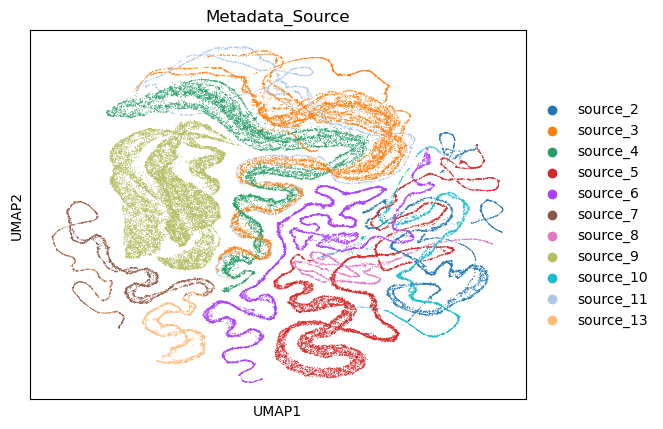

In [35]:
sc.pl.umap(adata, color="Metadata_Source")

Btw.: source 7 and 13 belong to the same data generating center. All other sources are unique centers.

/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


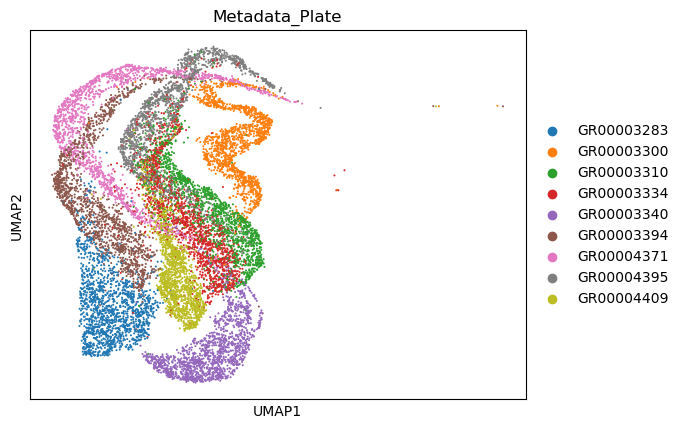

In [36]:
sc.pl.umap(adata[adata.obs.Metadata_Source=="source_9"], color="Metadata_Plate")

/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


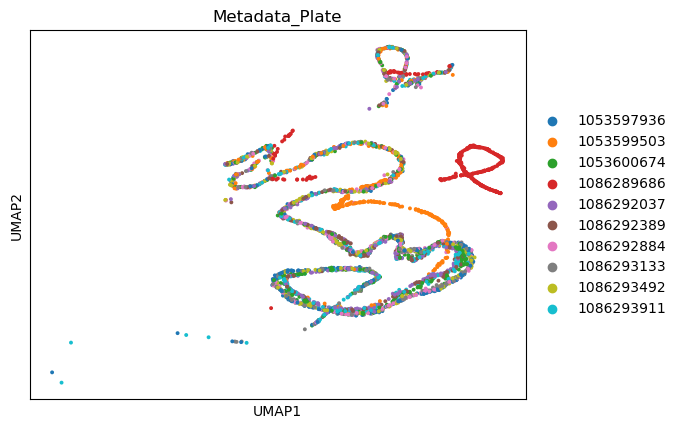

In [37]:
sc.pl.umap(adata[adata.obs.Metadata_Source=="source_2"], color="Metadata_Plate")

/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


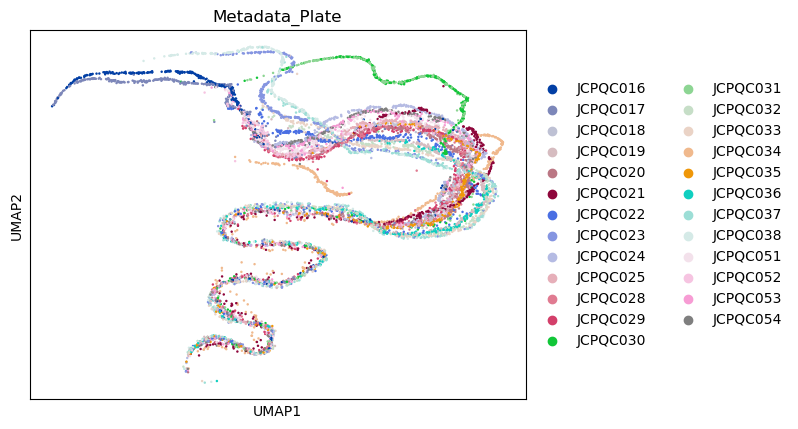

In [38]:
sc.pl.umap(adata[adata.obs.Metadata_Source=="source_3"], color="Metadata_Plate")

/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


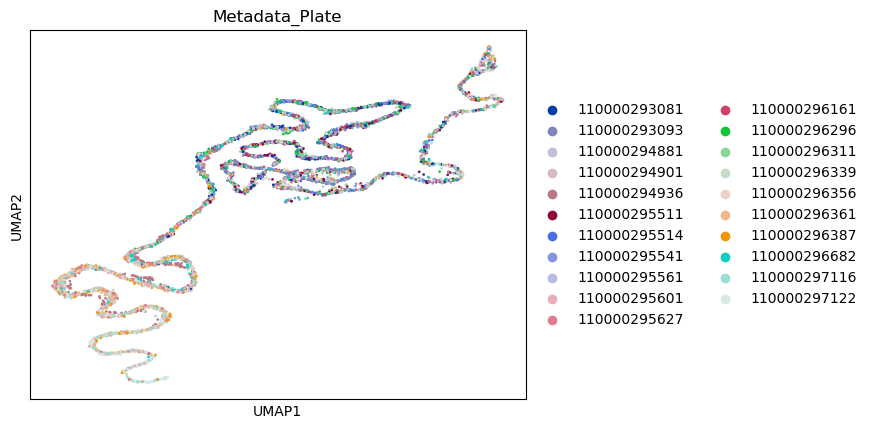

In [39]:
sc.pl.umap(adata[adata.obs.Metadata_Source=="source_6"], color="Metadata_Plate")

# Predict Metadata_Source with logistic regression

In [41]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=68)
train, test = [x for x in sss.split(adata.X, adata.obs.Metadata_Source)][0]

In [42]:
x_train = adata.X[train]
y_train = adata.obs.Metadata_Source[train]
x_test = adata.X[test]
y_test = adata.obs.Metadata_Source[test]

In [43]:
model_before = LogisticRegression(random_state=52).fit(x_train, y_train)

/home/stockhaus/miniconda3/envs/mp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
# performance on test set
y_test_pred_before = model_before.predict(x_test)
print("Confusion matrix: " + "\n"+str(confusion_matrix(y_test, y_test_pred_before)))
print("Balanced Accuracy: " + str(balanced_accuracy_score(y_test, y_test_pred_before)))
print("Recall (micro): " + str(recall_score(y_test, y_test_pred_before, average="micro")))
print("Recall (weighted): " + str(recall_score(y_test, y_test_pred_before, average="weighted")))
print("Precision (micro): " + str(precision_score(y_test, y_test_pred_before, average="micro")))
print("Precision (weighted): " + str(precision_score(y_test, y_test_pred_before, average="weighted")))

Confusion matrix: 
[[  11    0    0   14  201    0    0    4    0    0    0]
 [   0   22    8    5  233    0    0    0    0    0    0]
 [   0    0  156    0    0    0    0    0   52    0   20]
 [   2    0    0   29    0   31  262   59    0    0    0]
 [   0    0    5    0  916   39    0    0    0    0    0]
 [   1    0    0    0   88  718    0    0    0    0   37]
 [   0    0    0   64    0    0  858    0    0    0    0]
 [   0    0    0    0    0    0   21  784    0    0    1]
 [   0    0   12    0    0    0    0    0  257    0    0]
 [   4    0    0    0   75   61    1    1    0    9    3]
 [   0    0    0    0    0   53    0    0    0    0 1330]]
Balanced Accuracy: 0.5975928683565994
Recall (micro): 0.7895145028695517
Recall (weighted): 0.7895145028695517
Precision (micro): 0.7895145028695517
Precision (weighted): 0.7903258790673903
